In [1]:
import os
import pickle
from glob import glob

import climlab
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tqdm
import xarray as xr

In [2]:
BASE_DIR = "/gws/nopw/j04/ai4er/users/pn341/climate-rl-fedrl"
RECORDS_DIR = f"{BASE_DIR}/records"
DATASETS_DIR = f"{BASE_DIR}/datasets"
IMGS_DIR = f"{BASE_DIR}/results/imgs/"

In [3]:
fp_Ts = f"{DATASETS_DIR}/skt.sfc.mon.1981-2010.ltm.nc"
ncep_url = "http://www.esrl.noaa.gov/psd/thredds/dodsC/Datasets/ncep.reanalysis.derived/"


def download_and_save_dataset(url, filepath, dataset_name):
    if not os.path.exists(filepath):
        print(f"Downloading {dataset_name} data ...")
        dataset = xr.open_dataset(url, decode_times=False)
        dataset.to_netcdf(filepath, format="NETCDF3_64BIT")
        print(f"{dataset_name} data saved to {filepath}")
    else:
        print(f"Loading {dataset_name} data ...")
        dataset = xr.open_dataset(
            filepath,
            decode_times=xr.coders.CFDatetimeCoder(use_cftime=True),
        )
    return dataset


ncep_Ts = download_and_save_dataset(
    ncep_url + "surface_gauss/skt.sfc.mon.1981-2010.ltm.nc",
    fp_Ts,
    "NCEP surface temperature",
).sortby("lat")

lat_ncep = ncep_Ts.lat
lon_ncep = ncep_Ts.lon
Ts_ncep_annual = ncep_Ts.skt.mean(dim=("lon", "time"))

climlab_ebm = climlab.EBM_annual(num_lat=96)
Ts_ncep_annual = Ts_ncep_annual.interp(lat=climlab_ebm.lat, kwargs={"fill_value": "extrapolate"})
Ts_ncep_annual = np.array(Ts_ncep_annual)

for i in range(200):
    climlab_ebm.step_forward()

Loading NCEP surface temperature data ...


In [4]:
record_fns = glob(f"{RECORDS_DIR}/*ebm-v*/*/*_20000.pkl")   
algos = {"ddpg", "td3", "tqc"}
record_fns = [
    fn for fn in record_fns
    if any(algo in os.path.basename(os.path.dirname(fn)) for algo in algos)
]

In [5]:
from multiprocessing import Pool, cpu_count


def get_single_error_row(record_fn):
    try:
        with open(record_fn, "rb") as f:
            exp_id, algo = record_fn.split("/")[-3:-1]
            record = np.array(pickle.load(f))

            if "ppo" in record_fn or "trpo" in record_fn:
                record = record[-1]
                
            error = np.mean((Ts_ncep_annual - record.reshape(-1)) ** 2)
            
            return {
                "exp_id": exp_id,
                "algo": algo,
                "error": error,
                "fn": record_fn
            }
    except Exception as e:
        print(f"Failed to process {record_fn}: {e}")
        return None


def get_error_rows(record_fns):
    with Pool(processes=cpu_count()-2) as pool:
        results = list(tqdm.tqdm(pool.imap_unordered(get_single_error_row, record_fns), total=len(record_fns)))
    return [row for row in results if row is not None]

In [6]:
df = pd.DataFrame(get_error_rows(record_fns))
df = df.sort_values("error", ascending=True)
df.head()

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 10460.15it/s]


,exp_id,algo,error,fn
191,x9_ebm-v1-optim-L-20k_2025-07-11_21-52,EnergyBalanceModel-v1__ddpg_torch__5__1752267178,11.104986,/gws/nopw/j04/ai4er/users/pn341/climate-rl-fed...
14,ebm-v1-homo-64L-20k_2025-07-11_21-15,EnergyBalanceModel-v1__td3_torch__1__1752265080,11.885682,/gws/nopw/j04/ai4er/users/pn341/climate-rl-fed...
198,x9_ebm-v1-optim-L-20k_2025-07-11_21-52,EnergyBalanceModel-v1__ddpg_torch__3__1752267179,13.052684,/gws/nopw/j04/ai4er/users/pn341/climate-rl-fed...
185,x9_ebm-v1-optim-L-20k_2025-07-11_21-52,EnergyBalanceModel-v1__ddpg_torch__9__1752267478,14.548183,/gws/nopw/j04/ai4er/users/pn341/climate-rl-fed...
13,ebm-v1-homo-64L-20k_2025-07-11_21-15,EnergyBalanceModel-v1__ddpg_torch__1__1752264961,14.840833,/gws/nopw/j04/ai4er/users/pn341/climate-rl-fed...


In [7]:
from base64 import b64encode

from IPython.display import HTML

video_path = df.values[0][3].replace("/records/", "/videos/").replace("step_20000.pkl", "rl-video-episode-99.mp4")
mp4 = open(video_path, 'rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML(f"""
<video width=1280 controls>
    <source src="{data_url}" type="video/mp4">
</video>
""")

In [8]:
def plot_30_zone_errors(record_fn):
    exp_id = record_fn.split('/')[-3].split('_')[1] if 'x9' in record_fn else record_fn.split('/')[-3].split('_')[0]
    algo = record_fn.split('/')[-2].split("__")[1].split("_")[0]
    seed = record_fn.split('/')[-2].split("__")[2]
    
    with open(record_fn, "rb") as f:
        record = np.array(pickle.load(f))
        error_RL = Ts_ncep_annual - record.reshape(-1)
        error_climlab = Ts_ncep_annual - np.array(climlab_ebm.Ts).reshape(-1)
    
    bins = [-90, -60, -30, 0, 30, 60, 90]
    labels = ["90°S–60°S", "60°S–30°S", "30°S–0°", "0°–30°N", "30°N–60°N", "60°N–90°N"]
    ebm_means = []
    climlab_means = []
    
    for i in range(len(bins)-1):
        idx = (climlab_ebm.lat >= bins[i]) & (climlab_ebm.lat < bins[i+1])
        ebm_means.append(np.mean(np.abs(error_RL[idx])))
        climlab_means.append(np.mean(np.abs(error_climlab[idx])))
    
    x = np.arange(len(labels))
    width = 0.35
    
    plt.figure()
    bars1 = plt.bar(x - width/2, ebm_means, width, label="EBM Model w/ RL")
    bars2 = plt.bar(x + width/2, climlab_means, width, label="EBM Model")
    
    plt.xticks(x, labels)
    plt.ylabel("Mean Error (°C)")
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    
    for bar in bars1 + bars2:
        height = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width()/2,
            height + 0.05,
            f"{height:.2f}",
            ha='center',
            va='bottom',
            fontsize=9
        )
    
    plt.tight_layout()
    output_path = f"{IMGS_DIR}/ebm_{exp_id}_{algo}_{seed}_30_bin_errors.png"
    plt.savefig(output_path, dpi=300, bbox_inches="tight")

/gws/nopw/j04/ai4er/users/pn341/climate-rl-fedrl/records/x9_ebm-v1-optim-L-20k_2025-07-11_21-52/EnergyBalanceModel-v1__ddpg_torch__5__1752267178/step_20000.pkl


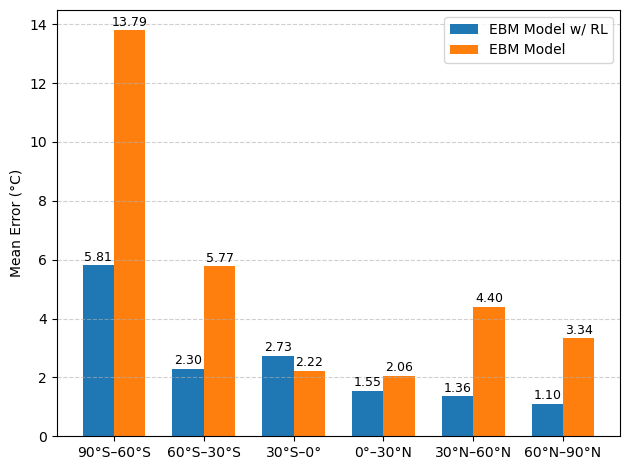

In [9]:
print(df.values[0][3])
plot_30_zone_errors(df.values[0][3])

In [10]:
record_fns = glob(f"{RECORDS_DIR}/*ebm-v*/*tqc*/step_20000.pkl")
tqc_df = pd.DataFrame(get_error_rows(record_fns))
tqc_df = tqc_df.sort_values("error", ascending=True)
tqc_df.head()       

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 80/80 [00:00<00:00, 7430.29it/s]


,exp_id,algo,error,fn
76,x9_ebm-v1-optim-L-20k_2025-07-11_21-52,EnergyBalanceModel-v1__tqc_torch__3__1752412632,22.492505,/gws/nopw/j04/ai4er/users/pn341/climate-rl-fed...
66,x9_ebm-v1-optim-L-20k_2025-07-11_21-52,EnergyBalanceModel-v1__tqc_torch__6__1752413232,23.918322,/gws/nopw/j04/ai4er/users/pn341/climate-rl-fed...
4,ebm-v1-optim-L-20k_2025-07-11_20-43,EnergyBalanceModel-v1__tqc_torch__1__1752356542,24.106953,/gws/nopw/j04/ai4er/users/pn341/climate-rl-fed...
78,x9_ebm-v1-optim-L-20k_2025-07-11_21-52,EnergyBalanceModel-v1__tqc_torch__8__1752413871,24.230578,/gws/nopw/j04/ai4er/users/pn341/climate-rl-fed...
69,x9_ebm-v1-optim-L_2025-07-11_22-10,EnergyBalanceModel-v1__tqc_torch__3__1752415950,24.439626,/gws/nopw/j04/ai4er/users/pn341/climate-rl-fed...


/gws/nopw/j04/ai4er/users/pn341/climate-rl-fedrl/records/x9_ebm-v1-optim-L-20k_2025-07-11_21-52/EnergyBalanceModel-v1__tqc_torch__3__1752412632/step_20000.pkl


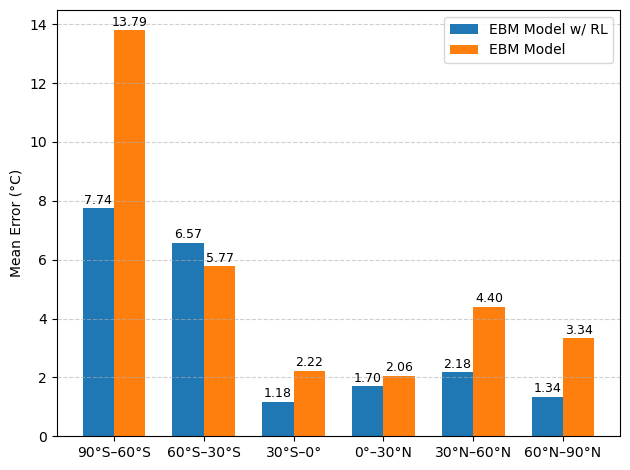

In [11]:
print(tqc_df.values[0][3])
plot_30_zone_errors(tqc_df.values[0][3])

In [12]:
record_fns = glob(f"{RECORDS_DIR}/*ebm-v*/*td3*/step_20000.pkl")
td3_df = pd.DataFrame(get_error_rows(record_fns))
td3_df = td3_df.sort_values("error", ascending=True)
td3_df.head()       

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 80/80 [00:00<00:00, 8912.91it/s]


,exp_id,algo,error,fn
1,ebm-v1-homo-64L-20k_2025-07-11_21-15,EnergyBalanceModel-v1__td3_torch__1__1752265080,11.885682,/gws/nopw/j04/ai4er/users/pn341/climate-rl-fed...
40,x9_ebm-v1-homo-64L-20k_2025-07-11_22-28,EnergyBalanceModel-v1__td3_torch__2__1752269422,18.364068,/gws/nopw/j04/ai4er/users/pn341/climate-rl-fed...
9,ebm-v1-homo-64L_2025-07-11_21-31,EnergyBalanceModel-v1__td3_torch__1__1752266039,18.691613,/gws/nopw/j04/ai4er/users/pn341/climate-rl-fed...
51,x9_ebm-v1-homo-64L-20k_2025-07-11_22-28,EnergyBalanceModel-v1__td3_torch__4__1752269422,25.349213,/gws/nopw/j04/ai4er/users/pn341/climate-rl-fed...
43,x9_ebm-v1-homo-64L-20k_2025-07-11_22-28,EnergyBalanceModel-v1__td3_torch__10__1752269424,25.514907,/gws/nopw/j04/ai4er/users/pn341/climate-rl-fed...


/gws/nopw/j04/ai4er/users/pn341/climate-rl-fedrl/records/ebm-v1-homo-64L-20k_2025-07-11_21-15/EnergyBalanceModel-v1__td3_torch__1__1752265080/step_20000.pkl


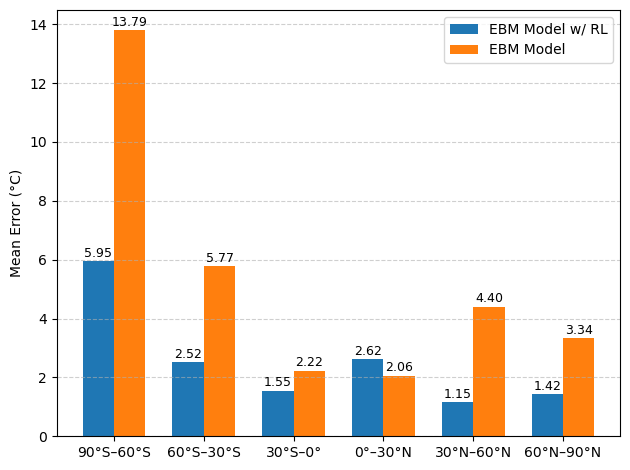

In [13]:
print(td3_df.values[0][3])
plot_30_zone_errors(td3_df.values[0][3])